✅ Download complete. The file has been saved in the '../data/raw_data' folder.
Displaying a map of the downloaded soil data...


c:\Users\Punith\OneDrive\Desktop\ML_data_Science_100_days_project\.venv\Lib\site-packages\xarray\plot\utils.py:258: RuntimeWarning: overflow encountered in scalar absolute
  vlim = max(abs(vmin - center), abs(vmax - center))


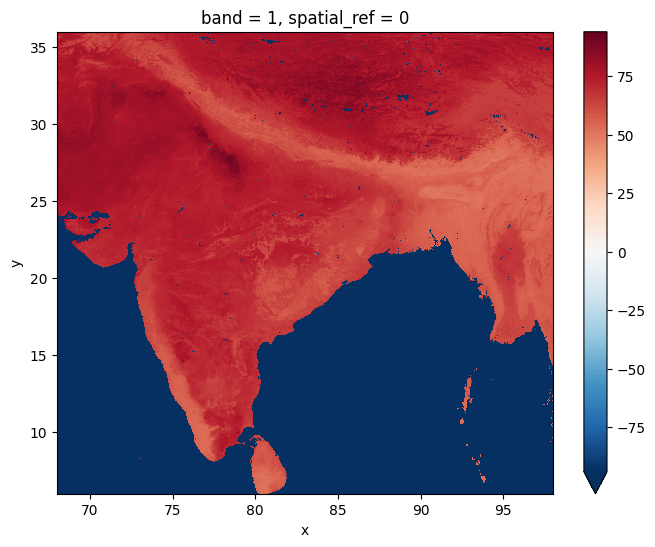

In [3]:
import os
from soilgrids import SoilGrids

# --- I'll set up the output directory ---
output_dir = "../data/raw_data"
os.makedirs(output_dir, exist_ok=True)
output_filepath = os.path.join(output_dir, "soil_ph_india.tif")

# --- Now I'll download the data ---
sg = SoilGrids()

print(f"Downloading soil pH data to '{output_filepath}'...")

data = sg.get_coverage_data(
    service_id="phh2o",
    coverage_id="phh2o_0-5cm_mean",
    west=68, south=6, east=98, north=36,
    crs="urn:ogc:def:crs:EPSG::4326",
    # I'm adding the required width and height parameters here.
    width=1000,
    height=1000,
    output=output_filepath
)

print(
    f"✅ Download complete. The file has been saved in the '{output_dir}' folder.")

# I'll plot the data to get a visual confirmation.
print("Displaying a map of the downloaded soil data...")
data.plot(figsize=(8, 6))

In [8]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd

# --- 1. Load the digital map of India's districts ---
print("Loading district map of India...")
districts_url = "https://raw.githubusercontent.com/geohacker/india/master/district/india_district.geojson"
districts_gdf = gpd.read_file(districts_url)

# --- This is the new line to find the correct column name ---
# It will print a list of all available column names in the map file.
print("\nAvailable columns in the map file:", districts_gdf.columns)

Loading district map of India...

Available columns in the map file: Index(['ID_0', 'ISO', 'NAME_0', 'ID_1', 'NAME_1', 'ID_2', 'NAME_2',
       'NL_NAME_2', 'VARNAME_2', 'TYPE_2', 'ENGTYPE_2', 'geometry'],
      dtype='object')


In [9]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd

# --- 1. Load the digital map of India's districts ---
# This part is already done, but I'm including it for completeness.
print("Loading district map of India...")
districts_url = "https://raw.githubusercontent.com/geohacker/india/master/district/india_district.geojson"
districts_gdf = gpd.read_file(districts_url)

# --- This is the corrected section ---
# I'm selecting the 'NAME_2' column, which contains the district names.
districts_gdf = districts_gdf[['NAME_2', 'geometry']]
# I'll rename it to 'District' for consistency with your other datasets.
districts_gdf.rename(columns={'NAME_2': 'District'}, inplace=True)


# --- 2. Extract the average pH for each district ---
print("\nExtracting soil pH for each district... (This may take a few minutes)")
soil_ph_values = []

with rasterio.open("../data/raw_data/soil_ph_india.tif") as src:
    for index, row in districts_gdf.iterrows():
        try:
            out_image, out_transform = mask(src, [row['geometry']], crop=True)
            # I'll calculate the average value, ignoring any 'no data' pixels.
            mean_val = np.mean(out_image[out_image != src.nodata])
            soil_ph_values.append(mean_val)
        except (ValueError, IndexError):
            # If a district is outside the raster's bounds, I'll append a null value.
            soil_ph_values.append(np.nan)

districts_gdf['pH'] = soil_ph_values


# --- 3. Create and save the final CSV file ---
soil_data_df = pd.DataFrame(districts_gdf[['District', 'pH']])
output_csv_path = "../data/raw_data/soil_data.csv"
soil_data_df.to_csv(output_csv_path, index=False)

print(f"\n✅ Success! A new file 'soil_data.csv' has been created.")
print("Here are the first 5 rows of your new soil data:")
print(soil_data_df.head())

Loading district map of India...

Extracting soil pH for each district... (This may take a few minutes)


c:\Users\Punith\OneDrive\Desktop\ML_data_Science_100_days_project\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Punith\OneDrive\Desktop\ML_data_Science_100_days_project\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



✅ Success! A new file 'soil_data.csv' has been created.
Here are the first 5 rows of your new soil data:
          District         pH
0  Andaman Islands  55.420561
1  Nicobar Islands  52.750000
2         Adilabad  69.975706
3        Anantapur  70.379444
4         Chittoor  68.944206
